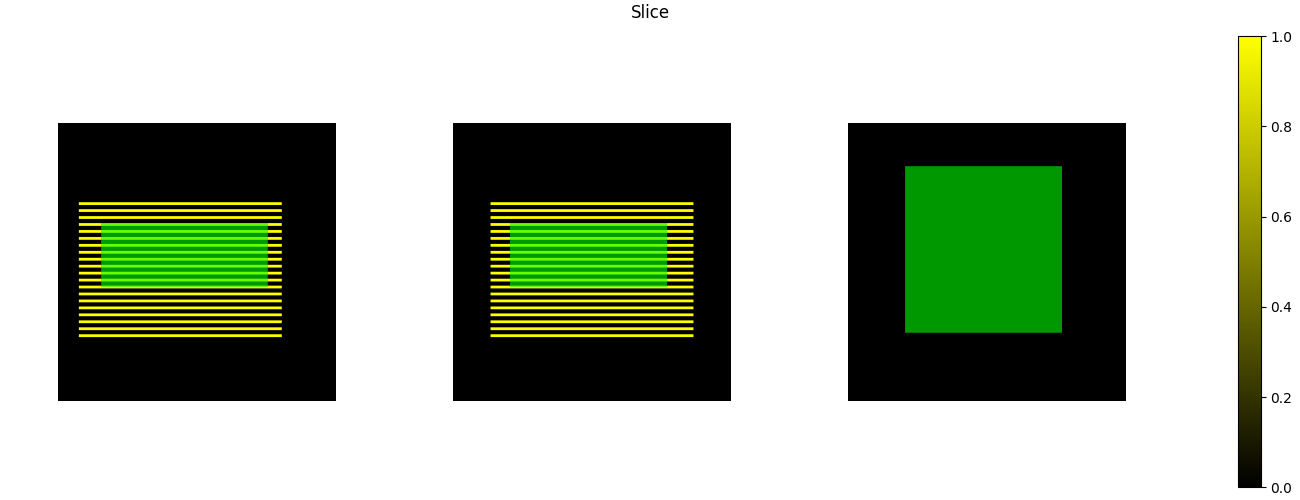

In [1]:
%matplotlib widget
from recotwix.prot_volumes import prot_volumes
from pytools import plot

file_protocol  = '/DATA2/rawdata/pyshim_data//soda/soda2.txt'
work_directory = '/DATA2/rawdata/pyshim_data/temp_nii/'

prot    = prot_volumes(file_protocol)
target_nii = prot.get('adj')[0]

combined_slc = prot.get('slc').get_combined()
combined_adj = prot.get('adj').get_combined()

plot.plot3D_siemens(combined_slc, combined_adj, cmap=[plot.YELLOW, plot.GREEN_T], alpha=0.6, clim=[[0,1]], title='Slice')


Software version: VD/VE (!?)

Scan  0


100%|██████████| 931M/931M [00:01<00:00, 709MB/s] 


Extracting kspace...
kspace original shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 80, 1, 1, 108, 32, 108]), scantype: image
kspace corrected shape  : torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 80, 1, 1, 108, 32, 110]), scantype: image


k-space to image: 100%|██████████| 32/32 [00:00<00:00, 113.45it/s]


Calculating B0 map. ΔTE = 3500 μs
Masking brain...
[100%] BET: Performing 1000 of 1000 iterations.		
Unwrapping B0...


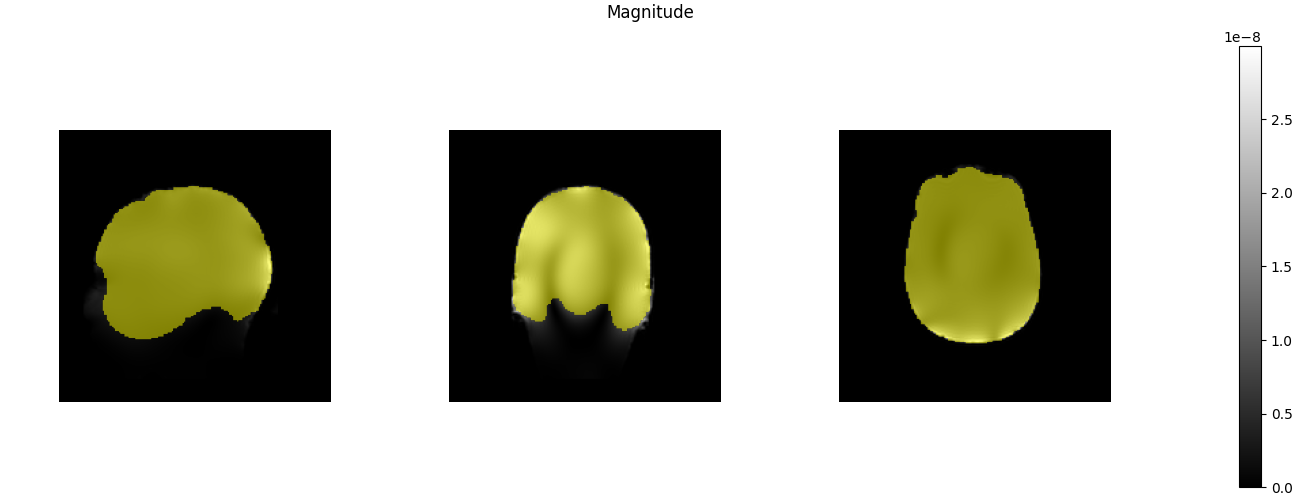

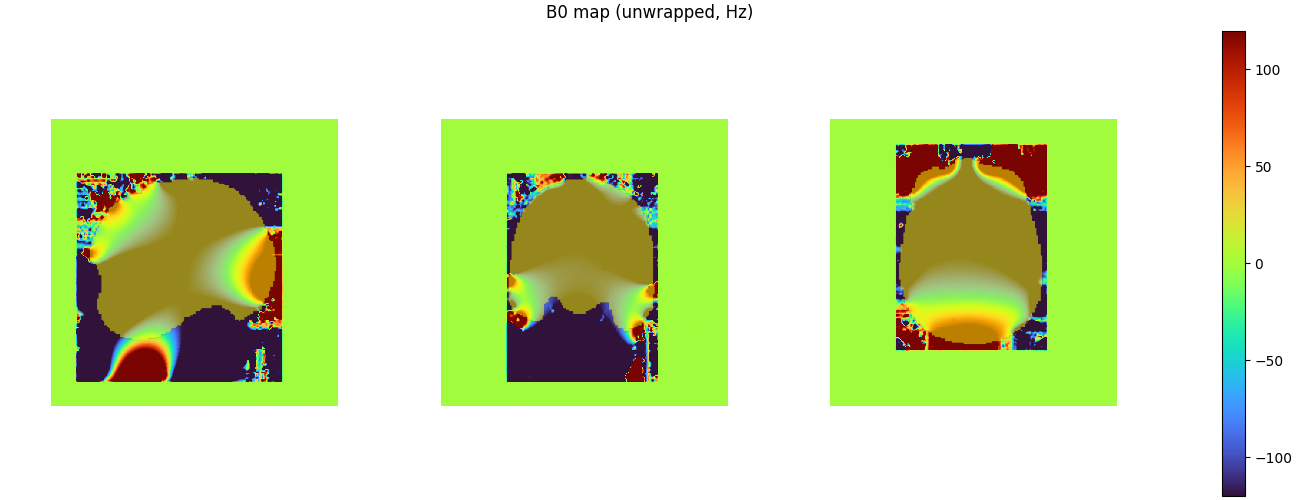

In [2]:
%matplotlib widget
from pytools import plot
from recotwix.sequences import recoB0
 
file_twix_B0   = '/DATA2/rawdata/pyshim_data/410.dat'
file_twix_B0   = '/DATA/aaghaeifar/rawdata/B0MapDataSet_7T/M700109/meas_MID00074_FID03504_aa_b0_Sag_WE_2_0mm.dat'
file_twix_B0   = '/DATA2/rawdata/pyshim_data/meas_MID00384_FID06346_B0_map.dat'

file_basismaps = '/DATA2/rawdata/pyshim_data/meas_MID00047_FID27956_aa_B0Mapping_2ndorder_IECO.nii'

b0_obj  = recoB0(file_twix_B0)

mag  = b0_obj.get_mag() ** 0.8
mask = b0_obj.mask_brain(mag, erode_size=3)

mag_nii  = b0_obj.make_nifti(mag)
mask_nii = b0_obj.make_nifti(mask)
b0_nii   = b0_obj.make_nifti(b0_obj.get_b0hz())

plot.plot3D_siemens(mag_nii, mask_nii, cmap=['gray', plot.YELLOW_T], title='Magnitude')
plot.plot3D_siemens(b0_nii, mask_nii, clim=[[-120, 120]], cmap=['turbo', plot.YELLOW_T], title='B0 map (unwrapped, Hz)')

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/513M [00:00<?, ?B/s]

100%|██████████| 513M/513M [00:01<00:00, 364MB/s] 


Extracting kspace...
kspace original shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 32, 48]), scantype: image
kspace corrected shape  : torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 32, 64]), scantype: image
POCS reconstruction along dim = Col started...
kspace original shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 24, 1, 1, 24, 32, 64]), scantype: refscan
kspace corrected shape  : torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 48, 1, 1, 64, 32, 64]), scantype: refscan
Computing coil sensitivity...
Calibration region 32x24x24
Done.
Combining coils... 


k-space to image: 100%|██████████| 32/32 [00:01<00:00, 18.32it/s]


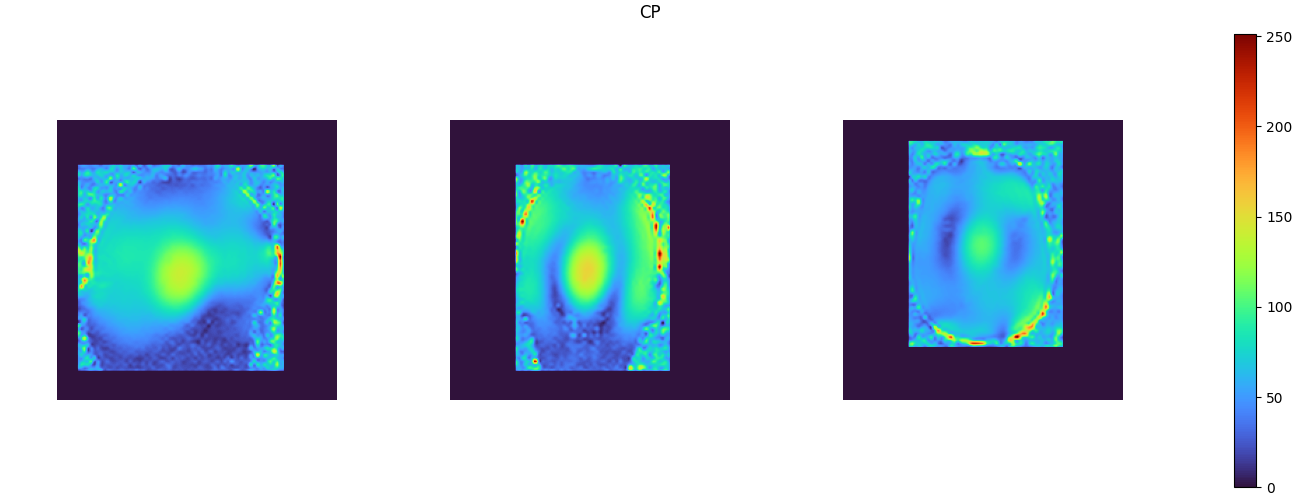

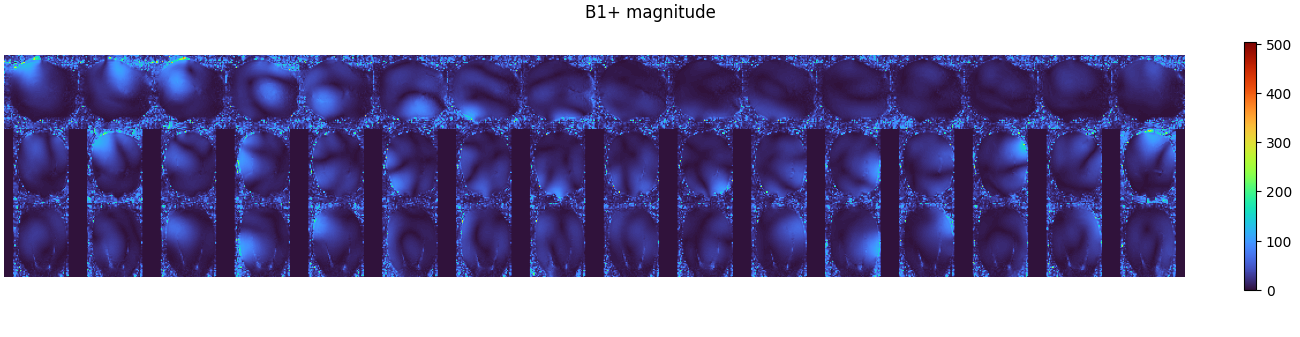

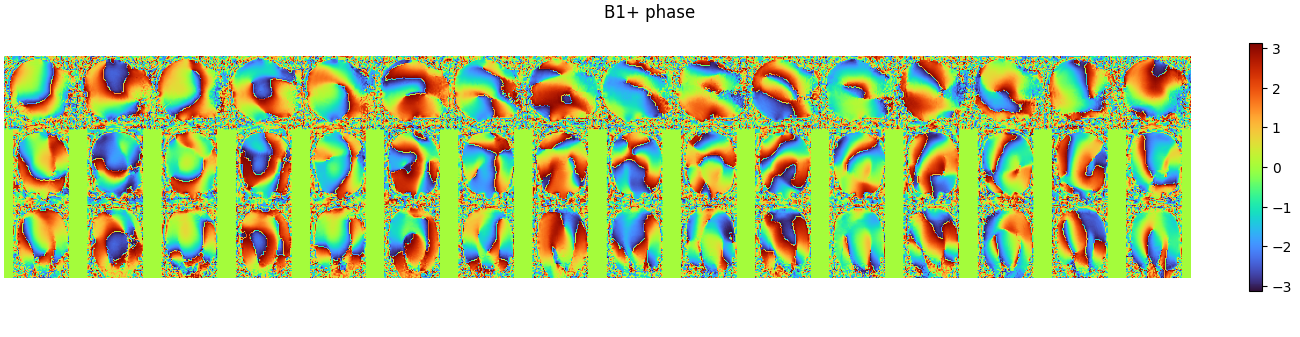

In [3]:
%matplotlib widget
from pytools import plot
from recotwix.sequences import recoB1TFLpTx

file_twix_B1 = '/DATA2/rawdata/twixtools_samples/meas_MID00866_FID61816_db_TFLb1_ICE_48Slc.dat'
file_twix_B1 = '/DATA2/rawdata/pyshim_data/meas_MID00383_FID06345_db_TFLb1_ICE_48Slc.dat'

b1_obj  = recoB1TFLpTx(file_twix_B1)
b1_nii      = b1_obj.make_nifti(b1_obj.img_b1)

plot.plot3D_siemens(b1_obj.make_nifti(b1_obj.img_cp.abs()), cmap=['turbo'], title='CP')
plot.plot4D_mosaic(b1_obj.reorder_dims(b1_obj.img_b1.abs()).detach().cpu().numpy(), title='B1+ magnitude')
plot.plot4D_mosaic(b1_obj.reorder_dims(b1_obj.img_b1.angle()).detach().cpu().numpy(), title='B1+ phase')


resampling to standard space: 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


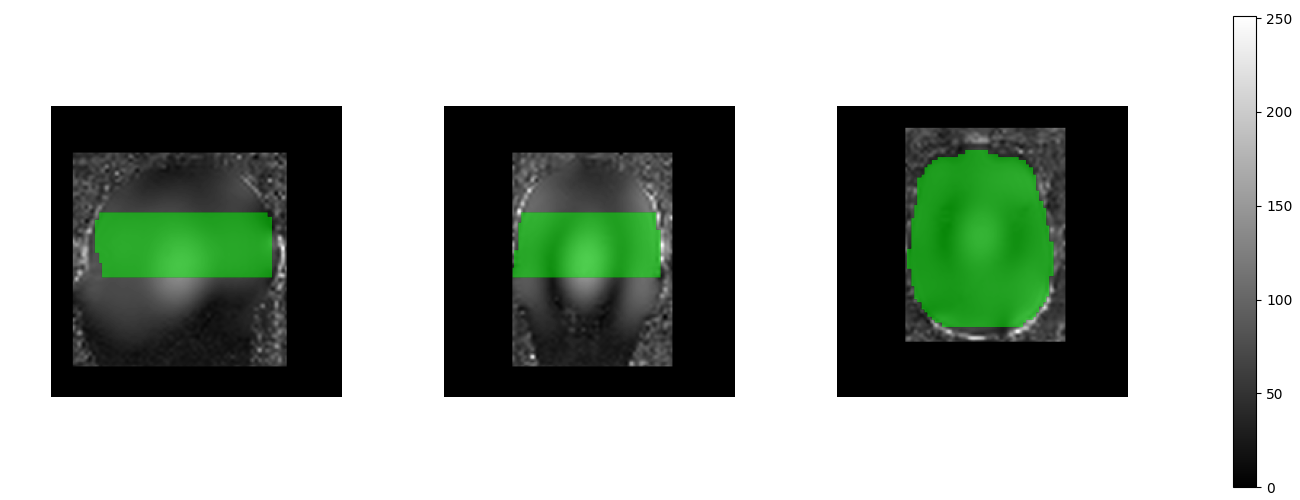

In [4]:
%matplotlib widget
import pyshim
from pytools import plot
import importlib
importlib.reload(pyshim)
# b0_hz.orthoview()
# b0_hz.slicer()

''' we resample to b1, not adj, since b1 is complex and resampling it to another space leads to error originated from b1 wrapped phase '''
std_affine, std_size = pyshim.create_standard_space(nifti_target=b1_nii)
targetr_nii, b0r_nii, maskr_nii = pyshim.resample_to_standard_sapce(target_nii, b0_nii, mask_nii, std_affine=std_affine, std_size=std_size)
mask_combined_nii = pyshim.combine_masks(maskr_nii, targetr_nii)
plot.plot3D_siemens(b1_obj.make_nifti(b1_obj.img_cp.abs()), mask_combined_nii, cmap=['gray', plot.GREEN_T])

In [5]:
import numpy as np
from pytools import plot
from pyshim import b1, opt
import importlib
importlib.reload(b1)
importlib.reload(opt)
importlib.reload(plot)

target_FA = 20
nRF   = 1 # number of subpulses
nTx   = b1_nii.shape[3] # number of transmit channels
rf_len = [1e-3]*nRF
rf_gap = [0]*(nRF-1)
A = b1.create_system_matrix(b1_nii, b0r_nii, mask_combined_nii, rf_len=rf_len, rf_gap=rf_gap) # A : nPos x nRF
target = np.ones(A.shape[0], dtype=np.float32) * target_FA / 180 * np.pi
voltages, err = opt.mls(A, target)
# it is very important to bear in mind that in A, col order is: [RF1_Tx1, RF2_Tx1, ..., RFN_Tx1, RF1_Tx2, RF2_Tx2, ..., RFN_Tx2, ...]
voltages = voltages.astype(np.complex64).reshape(nTx, nRF)
print(voltages.shape)
print(np.hstack((np.abs(voltages), np.angle(voltages))))

Loss=0.009/0.009:   0%|          | 0/50 [00:00<?, ?it/s]

Loss=0.004/0.009: 100%|██████████| 50/50 [00:00<00:00, 192.21it/s]

(16, 1)
[[ 3.7008579  -1.6142612 ]
 [ 4.6491833   0.58649653]
 [12.188999   -2.2077048 ]
 [ 9.269746   -0.36913764]
 [10.608811   -0.45202735]
 [11.895746    0.1916773 ]
 [ 7.292833    1.5226755 ]
 [11.83708     1.9931691 ]
 [ 3.2486906  -0.22374165]
 [12.834433    2.467516  ]
 [14.487709    1.2050875 ]
 [14.639945    3.0814383 ]
 [14.134138    2.3531904 ]
 [13.8145275  -1.8122563 ]
 [ 9.041143   -2.4910328 ]
 [11.361502   -0.46727157]]


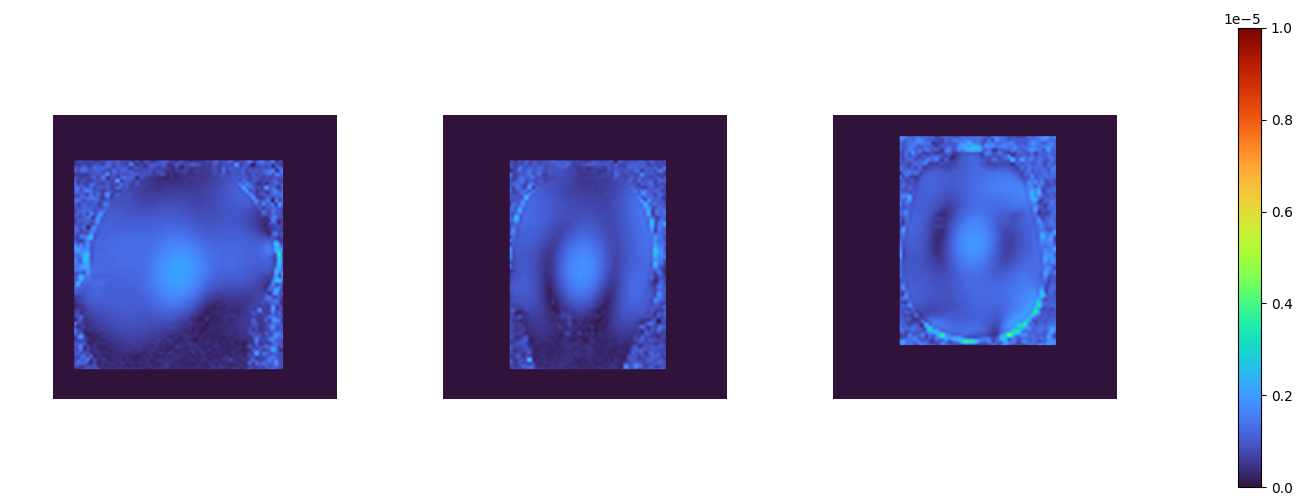

std and rmse (CP)  = [2.8575957e-07, 3.481607e-07]
std and rmse (pTx) = [2.4122883e-07, 2.456237e-07]


In [6]:
# simulate
from pyshim import calculate_err
from nilearn.image import math_img
importlib.reload(b1)

target_T = target_FA*np.pi/180/b1.gamma/rf_len[0] # target in Tesla
TraV = b1.calculate_transmit_voltage(b1_obj.prot.ref_voltage, target_FA, normalized_pulse_integral=0.001)
b1_comb_cp = b1.combine_pTx(b1_nii, b1_obj.seqTxScaleFactor.detach().cpu().numpy() * TraV, is_nTv=True) 
plot.plot3D_siemens(b1_comb_cp, cmap=['turbo'], clim=[[0, 1e-5]])

b1_comb_ptx = b1.combine_pTx(b1_nii, voltages[:,0], is_nTv=True) 

print(f'std and rmse (CP)  = {calculate_err(b1_comb_cp, mask_combined_nii, calc_rmse=True, target_rmse=target_T)}')
print(f'std and rmse (pTx) = {calculate_err(b1_comb_ptx, mask_combined_nii, calc_rmse=True, target_rmse=target_T)}')


In [7]:
from scipy.io import loadmat
importlib.reload(b1)
VOPs = loadmat(work_directory + '../RFSWDZZMat9003.bin.mat')['VOPs']
SAR = b1.calculate_SAR(voltages, VOPs, rf_len=rf_len, TR=20e-3)
print(f'SAR = {SAR} W/Kg')

Number of VOP Q-Matrices: 390
SAR = 3.8917418569326414 W/Kg


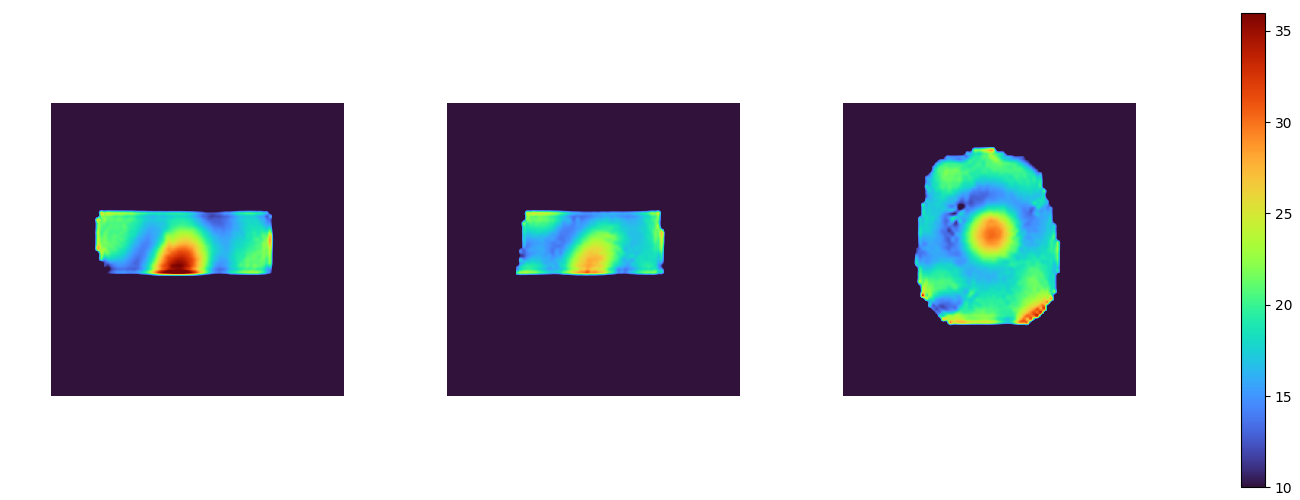

std and rmse (pTx) = [3.8229944774869855, 4.094444234856305]


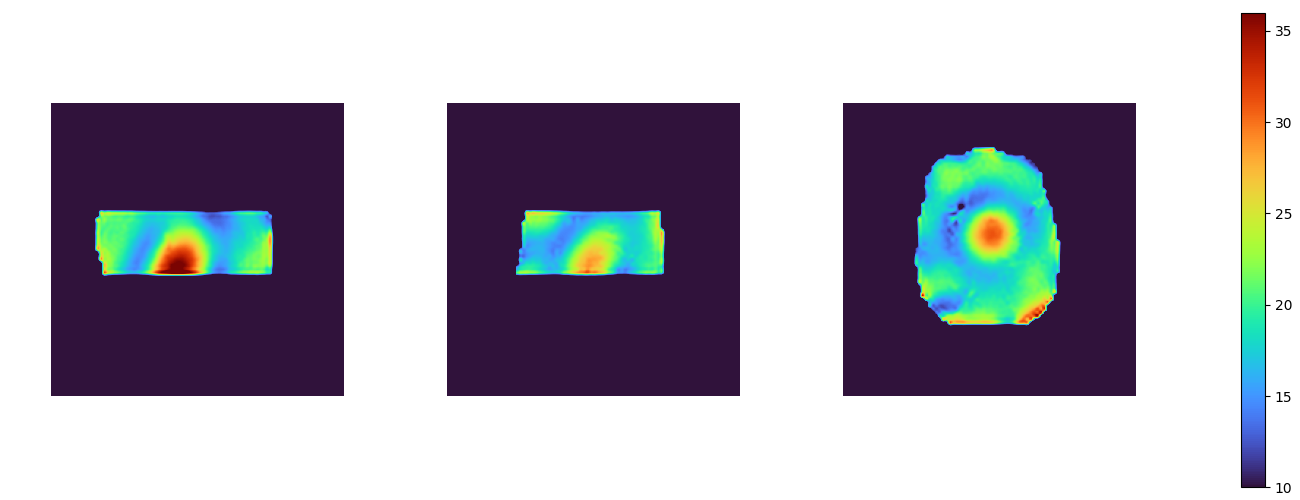

In [8]:
importlib.reload(b1)
result = b1.bloch_simulation(b1_nii, voltages, b0_nii=b0r_nii, mask_nii=mask_combined_nii, rf_len=rf_len, rf_gap=rf_gap)
plot.plot3D_siemens(result, cmap=['turbo'], clim=[[0.5*target_FA, 1.8*target_FA]])
print(f'std and rmse (pTx) = {calculate_err(result, mask_combined_nii, calc_rmse=True, target_rmse=target_FA)}')


b1_comb_ptx_FA = math_img('img1 * img2', img1=b1_comb_ptx, img2=mask_combined_nii)
b1_comb_ptx_FA = math_img(f'img*{180*b1.gamma*rf_len[0]/np.pi}', img=b1_comb_ptx_FA)
plot.plot3D_siemens(b1_comb_ptx_FA, cmap=['turbo'], clim=[[0.5*target_FA, 1.8*target_FA]])

In [9]:
%matplotlib widget
from recotwix.prot_volumes import prot_volumes
from pytools import plot

file_protocol  = '/DATA/aaghaeifar/mnt/upload9t/USERS/Ali/soda_dump.txt'
work_directory = '/DATA2/rawdata/pyshim_data/temp_nii/'

prot = prot_volumes(file_protocol)
prot.get('adj')[0].to_filename(work_directory + 'adj.nii')

combined_slc = prot.get('slc').get_combined()
combined_adj = prot.get('adj').get_combined()

plot.plot3D_siemens(combined_slc.get_fdata(), combined_adj.get_fdata(), affine=combined_slc.affine, cmap='gray', overlay_cmap='turbo', clim=[0,1], title='Slice')


TypeError: plot3D_siemens() got an unexpected keyword argument 'affine'

In [ ]:
# create list of random numpy array
import numpy as np
x = np.arange(20).reshape(4,5, order='F')
y = np.zeros((4,5))
y[2,:] = 1
mask = np.nonzero(y.flatten(order='F'))
out = np.ones(mask[0].shape) * 100

print(mask)
x.ravel(order='F')[mask] = out
print(x)




